# Using the Crop Tool for Chart Question Answering

This notebook demonstrates how giving Claude access to a **crop tool** can improve its performance on visual question answering tasks with charts and figures. We use the [FigureQA dataset](https://huggingface.co/datasets/vikhyatk/figureqa) to evaluate Claude's ability to answer yes/no questions about charts.

**This notebook covers two implementations:**
1. **Anthropic SDK** (`anthropic.Anthropic`) - Tools defined as JSON schema, passed to `messages.create()`
2. **Claude Agent SDK** (`ClaudeSDKClient`) - Tools defined with `@tool` decorator and registered via MCP servers

## How the Crop Tool Works

1. Claude receives a chart image and a question about it
2. Claude can call `crop_image` with normalized bounding box coordinates to zoom into a region
3. The cropped region is returned as a new image for Claude to analyze
4. Claude can crop multiple times or provide a final answer

This iterative zoom capability is particularly useful for:
- Comparing specific bars or data points in charts
- Reading exact values or labels that may be small
- Examining legend entries to identify colors
- Analyzing detailed chart elements

## Setup

First, let's install the required dependencies and set up our environment.

In [ ]:
import os
# Set your API key as an environment variable
# os.environ["ANTHROPIC_API_KEY"] = "your-api-key-here"

In [ ]:
%pip install anthropic pillow ipython datasets

In [111]:
import base64
import json
import random
from io import BytesIO

from anthropic import Anthropic
from datasets import load_dataset
from IPython.display import Image, display
from PIL import Image as PILImage

client = Anthropic()
MODEL_NAME = "claude-sonnet-4-5-20250929"

## Load the FigureQA Dataset

The [FigureQA dataset](https://huggingface.co/datasets/vikhyatk/figureqa) contains chart images with yes/no questions about them. Questions typically ask about:
- Comparisons ("Is X greater than Y?")
- Minimum/maximum values ("Is X the minimum?")
- Relative positions and relationships

We'll load a subset of images for our evaluation.

In [112]:
# Helper to convert image from dataset (may be dict or PIL Image)
def get_pil_image(img) -> PILImage.Image:
    """Convert dataset image to PIL Image."""
    if isinstance(img, PILImage.Image):
        return img
    elif isinstance(img, dict):
        # Handle dict format with 'bytes' or 'path' keys
        if 'bytes' in img and img['bytes']:
            return PILImage.open(BytesIO(img['bytes']))
        elif 'path' in img and img['path']:
            return PILImage.open(img['path'])
    raise ValueError(f"Cannot convert image of type {type(img)}")


# Load the FigureQA dataset
dataset = load_dataset("vikhyatk/figureqa", split="train")
print(f"Dataset size: {len(dataset)} samples")
print(f"Features: {dataset.features}")

Dataset size: 100000 samples
Features: {'image': Image(mode=None, decode=False), 'qa': List({'question': Value('string'), 'answer': Value('string')})}


In [113]:
# Look at a sample to understand the structure
sample = dataset[0]
image = get_pil_image(sample['image'])
print("Sample structure:")
print(f"  Image type: {type(sample['image'])} -> converted to {type(image)}")
print(f"  Image size: {image.size}")
print(f"  QA pairs: {len(sample['qa'])}")
print(f"\nSample QA pairs:")
for i, qa in enumerate(sample['qa'][:5]):
    print(f"  Q{i+1}: {qa['question']}")
    print(f"  A{i+1}: {qa['answer']}")

Sample structure:
  Image type: <class 'dict'> -> converted to <class 'PIL.PngImagePlugin.PngImageFile'>
  Image size: (776, 400)
  QA pairs: 10

Sample QA pairs:
  Q1: Is Pale Green the minimum?
  A1: No.
  Q2: Is Dark Red the maximum?
  A2: No.
  Q3: Is Pale Green greater than Dark Red?
  A3: Yes.
  Q4: Is Dark Red less than Pale Green?
  A4: Yes.
  Q5: Is Dark Red greater than Pale Green?
  A5: No.


Sample chart image:


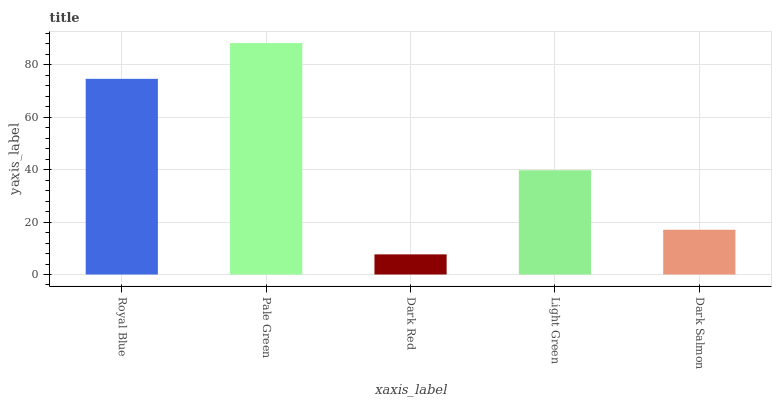

In [114]:
# Display a sample image
print("Sample chart image:")
display(get_pil_image(sample['image']))

In [115]:
def prepare_samples(dataset, num_samples: int = 50, seed: int = 42) -> list[dict]:
    """Prepare a subset of samples for evaluation.
    
    Each sample contains one image and one randomly selected QA pair.
    """
    random.seed(seed)
    
    # Sample random indices
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    samples = []
    for idx in indices:
        item = dataset[idx]
        # Randomly select one QA pair from the available ones
        qa = random.choice(item['qa'])
        samples.append({
            "id": f"sample_{idx}",
            "image": get_pil_image(item['image']),  # Convert to PIL Image
            "question": qa['question'],
            "true_answer": qa['answer'].lower().strip()
        })
    
    return samples


# Prepare evaluation samples
NUM_SAMPLES = 50  # Adjust based on your API budget
samples = prepare_samples(dataset, num_samples=NUM_SAMPLES)

# Count yes/no distribution
yes_count = sum(1 for s in samples if s['true_answer'] == 'yes')
no_count = sum(1 for s in samples if s['true_answer'] == 'no')
print(f"Prepared {len(samples)} samples")
print(f"  Yes answers: {yes_count}")
print(f"  No answers: {no_count}")

Prepared 50 samples
  Yes answers: 0
  No answers: 0


Let's look at a few sample questions:


--- Sample 1 ---
Question: Does Medium Orchid have the highest value?
True Answer: no.


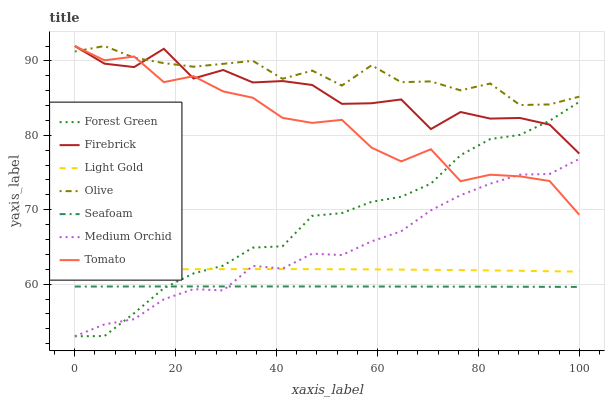


--- Sample 2 ---
Question: Is Cornflower the low median?
True Answer: yes.


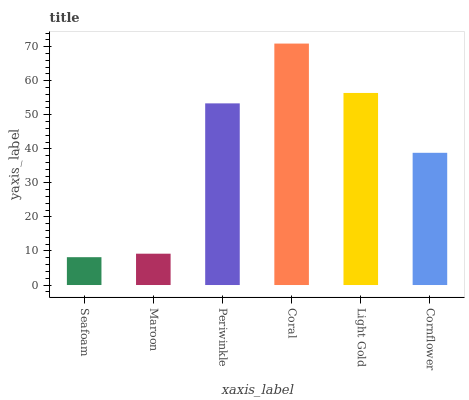


--- Sample 3 ---
Question: Is Dark Red greater than Steel Blue?
True Answer: yes.


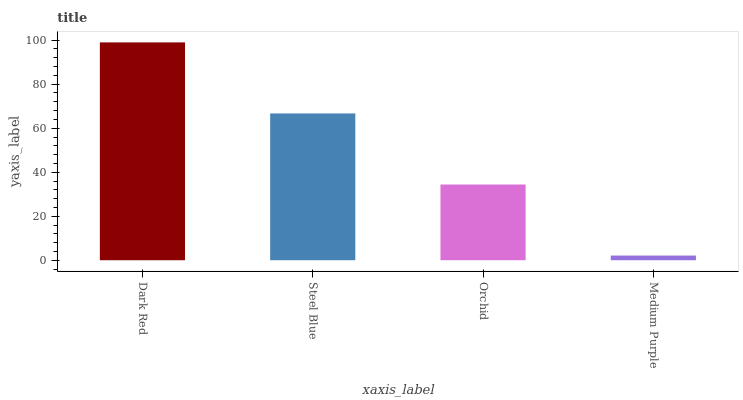

In [116]:
# Display a few samples with their questions
for i, sample in enumerate(samples[:3]):
    print(f"\n--- Sample {i+1} ---")
    print(f"Question: {sample['question']}")
    print(f"True Answer: {sample['true_answer']}")
    display(sample['image'])

## Helper Functions

Now let's define our helper functions for image encoding and the crop tool.

In [117]:
def pil_to_base64(image: PILImage.Image) -> str:
    """Convert a PIL Image to base64 string."""
    # Ensure image is in RGB mode for JPEG compatibility
    if image.mode in ('RGBA', 'P'):
        image = image.convert('RGB')
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    return base64.standard_b64encode(buffer.getvalue()).decode("utf-8")

## Define the Crop Tool

The crop tool allows Claude to specify a bounding box using normalized coordinates (0-1), where:
- `(0, 0)` is the top-left corner
- `(1, 1)` is the bottom-right corner
- `(0.5, 0.5)` is the center of the image

This normalized coordinate system makes it easy for Claude to specify regions regardless of the actual image dimensions.

In [118]:
# Tool definition following the Anthropic tool use format
CROP_TOOL = {
    "name": "crop_image",
    "description": "Crop a region of the chart image to examine it more closely. Use normalized coordinates (0-1) where (0,0) is the top-left corner and (1,1) is the bottom-right corner. This is useful for: examining specific bars/data points, reading axis labels, checking legend entries, or comparing adjacent elements.",
    "input_schema": {
        "type": "object",
        "properties": {
            "x1": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Left edge of crop region (0-1)"
            },
            "y1": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Top edge of crop region (0-1)"
            },
            "x2": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Right edge of crop region (0-1)"
            },
            "y2": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Bottom edge of crop region (0-1)"
            }
        },
        "required": ["x1", "y1", "x2", "y2"]
    }
}


def crop_image_handler(inputs: dict, image: PILImage.Image) -> list:
    """Handle crop tool call - returns cropped image for Claude to analyze."""
    x1, y1, x2, y2 = inputs["x1"], inputs["y1"], inputs["x2"], inputs["y2"]

    # Validate coordinates
    if not all(0 <= c <= 1 for c in [x1, y1, x2, y2]):
        return [{"type": "text", "text": "Error: Coordinates must be between 0 and 1"}]
    if x1 >= x2 or y1 >= y2:
        return [{"type": "text", "text": "Error: Invalid bounding box (x1 must be < x2, y1 must be < y2)"}]

    w, h = image.size
    left, top, right, bottom = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
    cropped = image.crop((left, top, right, bottom))

    # Return cropped image as base64 for Claude to see
    return [
        {"type": "text", "text": f"Cropped region: ({x1:.2f},{y1:.2f}) to ({x2:.2f},{y2:.2f}) - {cropped.width}x{cropped.height}px"},
        {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": pil_to_base64(cropped)}}
    ]

Let's test the crop tool to make sure it works:

Original image size: (609, 400)


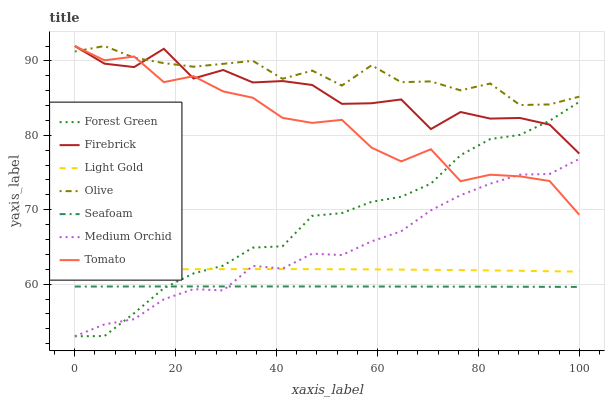


Cropped region: (0.60,0.00) to (1.00,0.30) - 244x120px
Cropped region (legend area):


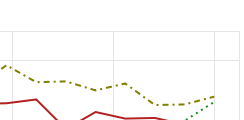

In [119]:
# Test the crop tool
test_image = samples[0]["image"]
print(f"Original image size: {test_image.size}")
display(test_image)

# Crop the legend area (typically top-right)
result = crop_image_handler({"x1": 0.6, "y1": 0.0, "x2": 1.0, "y2": 0.3}, test_image)
print(f"\n{result[0]['text']}")

# Display the cropped image
cropped_data = base64.b64decode(result[1]["source"]["data"])
print("Cropped region (legend area):")
display(Image(data=cropped_data))

## Question Answering Functions

Now let's define our QA functions - one for baseline (no tools) and one with the crop tool.

In [120]:
BASELINE_SYSTEM_PROMPT = """You are an expert at analyzing charts and figures.
You will be shown a chart image and asked a yes/no question about it.

Analyze the chart carefully and answer the question.

Respond with ONLY a JSON object in this exact format:
{"answer": "<yes.|no.>", "reasoning": "<brief explanation>"}"""

CROP_SYSTEM_PROMPT = """You are an expert at analyzing charts and figures.
You will be shown a chart image and asked a yes/no question about it.

You have access to a crop_image tool that lets you zoom into specific regions for closer examination.
This is useful for:
- Reading exact values on bars or data points
- Checking legend entries to identify colors
- Comparing adjacent elements more precisely
- Reading axis labels or small text

Use the crop tool if you need to examine any region more closely before answering.

When you're ready to provide your final answer, respond with ONLY a JSON object:
{"answer": "<yes.|no.>", "reasoning": "<brief explanation>"}"""


def extract_answer(text: str) -> dict:
    """Extract answer from Claude's response."""
    import re
    
    # First, try to parse the entire response as JSON
    try:
        result = json.loads(text.strip())
        return {
            "predicted_answer": result.get("answer", "unknown").lower().strip(),
            "reasoning": result.get("reasoning", "")
        }
    except json.JSONDecodeError:
        pass
    
    # Try to find JSON by matching balanced braces
    # Look for {"answer": pattern and extract until we find balanced braces
    for match in re.finditer(r'\{["\']answer["\']', text):
        start = match.start()
        brace_count = 0
        end = start
        
        for i, char in enumerate(text[start:], start):
            if char == '{':
                brace_count += 1
            elif char == '}':
                brace_count -= 1
                if brace_count == 0:
                    end = i + 1
                    break
        
        if end > start:
            try:
                result = json.loads(text[start:end])
                return {
                    "predicted_answer": result.get("answer", "unknown").lower().strip(),
                    "reasoning": result.get("reasoning", "")
                }
            except json.JSONDecodeError:
                continue
    
    # Fallback: try simple regex for just the answer field
    answer_match = re.search(r'"answer"\s*:\s*"([^"]+)"', text)
    if answer_match:
        return {
            "predicted_answer": answer_match.group(1).lower().strip(),
            "reasoning": "extracted answer only"
        }
    
    return {"predicted_answer": "unknown", "reasoning": "parse error"}

In [121]:
def answer_baseline(sample: dict) -> dict:
    """Answer a question without any tools (baseline)."""
    image_data = pil_to_base64(sample["image"])

    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=300,
        system=BASELINE_SYSTEM_PROMPT,
        messages=[{
            "role": "user",
            "content": [
                {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": image_data}},
                {"type": "text", "text": f"Question: {sample['question']}"}
            ]
        }]
    )

    result = extract_answer(response.content[0].text)
    return {
        "id": sample["id"],
        "question": sample["question"],
        "true_answer": sample["true_answer"],
        "tool_calls": 0,
        **result
    }

In [122]:
MAX_TOOL_CALLS = 9  # Limit tool calls to prevent infinite loops


def answer_with_crop(sample: dict) -> dict:
    """Answer a question with the crop tool available."""
    image = sample["image"]
    image_data = pil_to_base64(image)

    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": image_data}},
            {"type": "text", "text": f"Question: {sample['question']}\n\nUse crop_image if you need to examine any region more closely."}
        ]
    }]

    tool_calls = 0

    for _ in range(MAX_TOOL_CALLS + 1):  # +1 for final response
        response = client.messages.create(
            model=MODEL_NAME,
            max_tokens=1024,
            system=CROP_SYSTEM_PROMPT,
            tools=[CROP_TOOL],
            messages=messages
        )

        if response.stop_reason == "tool_use":
            # Process tool calls
            tool_results = []
            for block in response.content:
                if block.type == "tool_use":
                    tool_calls += 1
                    result = crop_image_handler(block.input, image)
                    tool_results.append({
                        "type": "tool_result",
                        "tool_use_id": block.id,
                        "content": result
                    })

            messages.append({"role": "assistant", "content": response.content})
            messages.append({"role": "user", "content": tool_results})
        else:
            # Got final answer
            final_text = next((b.text for b in response.content if hasattr(b, "text")), "")
            result = extract_answer(final_text)
            break
    else:
        # Exceeded max tool calls
        result = {"predicted_answer": "unknown", "reasoning": "max tools exceeded"}

    return {
        "id": sample["id"],
        "question": sample["question"],
        "true_answer": sample["true_answer"],
        "tool_calls": tool_calls,
        **result
    }

## Run Baseline Evaluation

First, let's answer all questions without the crop tool to establish a baseline.

In [123]:
print("Running BASELINE evaluation (no tools)...")
print("=" * 60)

baseline_results = []
for i, sample in enumerate(samples):
    print(f"[{i+1:2}/{len(samples)}]", end=" ")
    result = answer_baseline(sample)
    baseline_results.append(result)

    status = "correct" if result["true_answer"] == result["predicted_answer"] else "WRONG"
    print(f"{result['true_answer']:>3} -> {result['predicted_answer']:>7} [{status}]")

baseline_correct = sum(1 for r in baseline_results if r["true_answer"] == r["predicted_answer"])
print(f"\nBaseline Accuracy: {baseline_correct}/{len(baseline_results)} ({baseline_correct/len(baseline_results):.1%})")

Running BASELINE evaluation (no tools)...
[ 1/50] no. ->     no. [correct]
[ 2/50] yes. ->    yes. [correct]
[ 3/50] yes. ->    yes. [correct]
[ 4/50] yes. ->    yes. [correct]
[ 5/50] no. ->     no. [correct]
[ 6/50] yes. ->    yes. [correct]
[ 7/50] yes. ->     no. [WRONG]
[ 8/50] yes. ->    yes. [correct]
[ 9/50] yes. ->    yes. [correct]
[10/50] yes. ->    yes. [correct]
[11/50] no. ->     no. [correct]
[12/50] no. ->     no. [correct]
[13/50] no. ->     no. [correct]
[14/50] yes. ->    yes. [correct]
[15/50] no. ->     no. [correct]
[16/50] no. ->     no. [correct]
[17/50] yes. ->    yes. [correct]
[18/50] no. ->     no. [correct]
[19/50] no. ->     no. [correct]
[20/50] no. ->     no. [correct]
[21/50] yes. ->    yes. [correct]
[22/50] no. ->      no [WRONG]
[23/50] no. ->    yes. [WRONG]
[24/50] yes. ->    yes. [correct]
[25/50] yes. ->     no. [WRONG]
[26/50] yes. ->    yes. [correct]
[27/50] yes. ->    yes. [correct]
[28/50] no. ->     no. [correct]
[29/50] no. ->      no [WRO

## Run Evaluation WITH Crop Tool

Now let's run the same questions, but with the crop tool available.

In [124]:
print("Running evaluation WITH CROP TOOL...")
print("=" * 60)

crop_results = []
for i, sample in enumerate(samples):
    print(f"[{i+1:2}/{len(samples)}]", end=" ")
    result = answer_with_crop(sample)
    crop_results.append(result)

    status = "correct" if result["true_answer"] == result["predicted_answer"] else "WRONG"
    print(f"{result['true_answer']:>3} -> {result['predicted_answer']:>7} [{status}] (crops: {result['tool_calls']})")

crop_correct = sum(1 for r in crop_results if r["true_answer"] == r["predicted_answer"])
avg_crops = sum(r["tool_calls"] for r in crop_results) / len(crop_results)
print(f"\nCrop Tool Accuracy: {crop_correct}/{len(crop_results)} ({crop_correct/len(crop_results):.1%})")
print(f"Average crops per question: {avg_crops:.2f}")

Running evaluation WITH CROP TOOL...
[ 1/50] no. ->     no. [correct] (crops: 5)
[ 2/50] yes. ->    yes. [correct] (crops: 1)
[ 3/50] yes. ->    yes. [correct] (crops: 1)
[ 4/50] yes. ->    yes. [correct] (crops: 1)
[ 5/50] no. ->     no. [correct] (crops: 1)
[ 6/50] yes. ->    yes. [correct] (crops: 3)
[ 7/50] yes. ->    yes. [correct] (crops: 2)
[ 8/50] yes. ->    yes. [correct] (crops: 1)
[ 9/50] yes. ->    yes. [correct] (crops: 3)
[10/50] yes. ->    yes. [correct] (crops: 1)
[11/50] no. ->     no. [correct] (crops: 3)
[12/50] no. ->     no. [correct] (crops: 4)
[13/50] no. ->     no. [correct] (crops: 6)
[14/50] yes. ->     no. [WRONG] (crops: 8)
[15/50] no. ->     no. [correct] (crops: 3)
[16/50] no. ->     no. [correct] (crops: 2)
[17/50] yes. ->    yes. [correct] (crops: 3)
[18/50] no. ->     no. [correct] (crops: 1)
[19/50] no. ->     no. [correct] (crops: 1)
[20/50] no. ->     no. [correct] (crops: 3)
[21/50] yes. ->    yes. [correct] (crops: 1)
[22/50] no. ->     no. [correc

## Results Comparison

Let's compare the results and analyze where the crop tool helped (or didn't help).

In [125]:
def compute_metrics(results: list[dict]) -> dict:
    """Compute accuracy metrics."""
    total = len(results)
    correct = sum(1 for r in results if r["true_answer"] == r["predicted_answer"])
    
    # Metrics by true answer type - normalize by removing periods for comparison
    def normalize(answer: str) -> str:
        return answer.lower().strip().rstrip(".")
    
    yes_samples = [r for r in results if normalize(r["true_answer"]) == "yes"]
    no_samples = [r for r in results if normalize(r["true_answer"]) == "no"]
    
    yes_correct = sum(1 for r in yes_samples if normalize(r["predicted_answer"]) == "yes")
    no_correct = sum(1 for r in no_samples if normalize(r["predicted_answer"]) == "no")
    
    return {
        "overall_accuracy": correct / total if total > 0 else 0,
        "correct": correct,
        "total": total,
        "yes_accuracy": yes_correct / len(yes_samples) if yes_samples else 0,
        "no_accuracy": no_correct / len(no_samples) if no_samples else 0,
        "yes_total": len(yes_samples),
        "no_total": len(no_samples),
        "avg_crops": sum(r.get("tool_calls", 0) for r in results) / total if total > 0 else 0
    }


baseline_metrics = compute_metrics(baseline_results)
crop_metrics = compute_metrics(crop_results)

print("COMPARISON SUMMARY")
print("=" * 70)
print(f"{'Method':<25} {'Overall':>12} {'Yes Acc':>12} {'No Acc':>12} {'Avg Crops':>10}")
print("-" * 70)
print(f"{'Baseline (no tools)':<25} {baseline_metrics['overall_accuracy']:>11.1%} {baseline_metrics['yes_accuracy']:>11.1%} {baseline_metrics['no_accuracy']:>11.1%} {baseline_metrics['avg_crops']:>10.2f}")
print(f"{'With Crop Tool':<25} {crop_metrics['overall_accuracy']:>11.1%} {crop_metrics['yes_accuracy']:>11.1%} {crop_metrics['no_accuracy']:>11.1%} {crop_metrics['avg_crops']:>10.2f}")
print()

improvement = crop_metrics['overall_accuracy'] - baseline_metrics['overall_accuracy']
print(f"Overall Improvement: {improvement:+.1%}")
print(f"\n(Yes Acc = accuracy on 'yes' questions, No Acc = accuracy on 'no' questions)")

COMPARISON SUMMARY
Method                         Overall      Yes Acc       No Acc  Avg Crops
----------------------------------------------------------------------
Baseline (no tools)             62.0%       81.0%       82.8%       0.00
With Crop Tool                  88.0%       76.2%       96.6%       2.56

Overall Improvement: +26.0%

(Yes Acc = accuracy on 'yes' questions, No Acc = accuracy on 'no' questions)


## Analyze Individual Cases

Let's look at specific cases where the crop tool made a difference.

In [126]:
# Find cases where crop tool improved the result
improved_cases = []
for base, crop in zip(baseline_results, crop_results):
    base_correct = base["true_answer"] == base["predicted_answer"]
    crop_correct = crop["true_answer"] == crop["predicted_answer"]
    if crop_correct and not base_correct:
        improved_cases.append((base, crop))

# Find cases where crop tool made it worse
worsened_cases = []
for base, crop in zip(baseline_results, crop_results):
    base_correct = base["true_answer"] == base["predicted_answer"]
    crop_correct = crop["true_answer"] == crop["predicted_answer"]
    if base_correct and not crop_correct:
        worsened_cases.append((base, crop))

print(f"Cases where crop tool IMPROVED result: {len(improved_cases)}")
print(f"Cases where crop tool WORSENED result: {len(worsened_cases)}")
print(f"Net improvement: {len(improved_cases) - len(worsened_cases)} questions")

Cases where crop tool IMPROVED result: 16
Cases where crop tool WORSENED result: 3
Net improvement: 13 questions



CASES WHERE CROP TOOL HELPED

--- Example 1 ---
Question: Is Dark Green the high median?
True Answer: yes.

Baseline: no.
  Reasoning: Looking at the pie chart, the segments in order from largest to smallest are: Gray (largest), Dark Green (second), Purple (third), and Medium Seafoam (smallest). The median value would be between Dark Green and Purple. Since Dark Green is the second largest value, it is not the 'high median' (which would be closer to the largest value). The median would fall between the middle two values when ordered.

With Crop Tool (2 crops): yes.
  Reasoning: In a dataset with 4 values, the high median is the 3rd value when sorted from smallest to largest. The segments in order of size are: Medium Seafoam (smallest), Purple, Dark Green, and Gray (largest). Dark Green is the 3rd value, making it the high median.


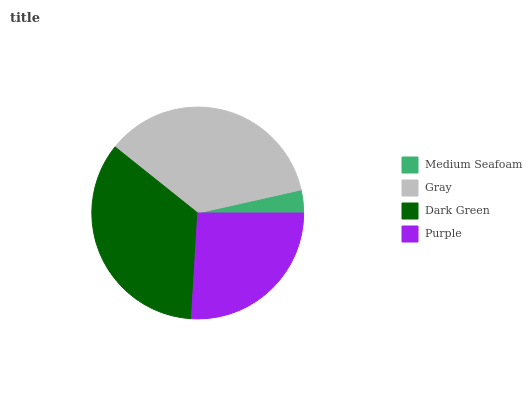


--- Example 2 ---
Question: Does Royal Blue have the minimum area under the curve?
True Answer: no.

Baseline: no
  Reasoning: Looking at the chart, Red has the lowest values throughout, staying at the bottom of the graph. Royal Blue is one of the higher-valued lines that fluctuates in the upper portion of the chart.

With Crop Tool (5 crops): no.
  Reasoning: Royal Blue is one of the upper lines in the chart, starting at around 40 and ending at around 35. Red is clearly the line with the minimum area under the curve, as it stays consistently at the bottom of the chart, ranging from approximately 5 to 19. Royal Blue has a much larger area under its curve compared to Red.


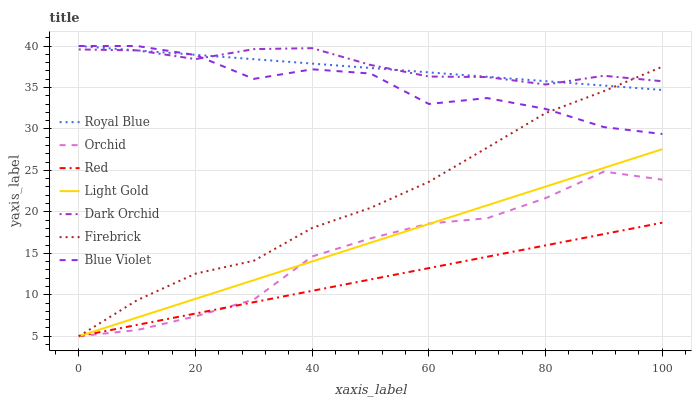


--- Example 3 ---
Question: Is Violet Red the roughest?
True Answer: no.

Baseline: yes.
  Reasoning: Violet Red (purple dashed line) shows the most variation and abrupt changes in its trajectory, with sharp drops and level sections, making it appear the roughest compared to the other smoother, more linear trends.

With Crop Tool (4 crops): no.
  Reasoning: Violet Red is not the roughest line. It is one of the smoothest lines in the chart, maintaining a nearly flat trajectory around y=20 throughout the entire x-axis range. The Cyan line appears to be the roughest, with a sharp drop around x=20 creating an abrupt change in direction.


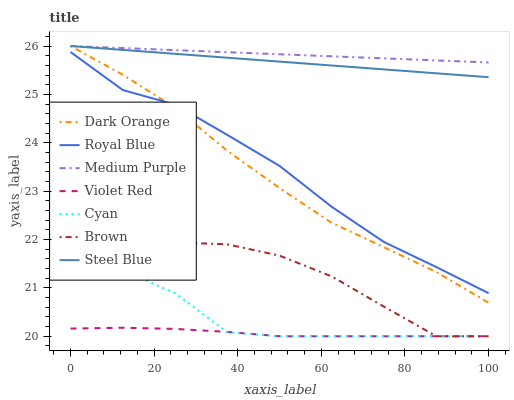

In [127]:
# Show examples of improved cases
if improved_cases:
    print("\n" + "="*60)
    print("CASES WHERE CROP TOOL HELPED")
    print("="*60)
    
    for i, (base, crop) in enumerate(improved_cases[:3]):  # Show up to 3
        # Find the original sample
        sample = next(s for s in samples if s["id"] == base["id"])
        
        print(f"\n--- Example {i+1} ---")
        print(f"Question: {base['question']}")
        print(f"True Answer: {base['true_answer']}")
        print(f"\nBaseline: {base['predicted_answer']}")
        print(f"  Reasoning: {base.get('reasoning', 'N/A')}")
        print(f"\nWith Crop Tool ({crop['tool_calls']} crops): {crop['predicted_answer']}")
        print(f"  Reasoning: {crop.get('reasoning', 'N/A')}")
        display(sample['image'])


CASES WHERE CROP TOOL HURT

--- Example 1 ---
Question: Is Aqua the low median?
True Answer: yes.

Baseline: yes.
  Reasoning: When examining the pie chart, I need to identify the median value. Looking at the sizes of the segments, Aqua appears to be one of the smaller segments. Comparing all six segments (Aqua, Light Green, Pale Green, Light Gold, Green Yellow, and Light Seafoam), Aqua is indeed among the smaller portions, making it the low median value when segments are ordered by size.

With Crop Tool (8 crops): no.
  Reasoning: When ordering the six segments from smallest to largest, Aqua appears to be the 2nd smallest segment. The low median (3rd position out of 6 values) appears to be Light Gold, not Aqua.


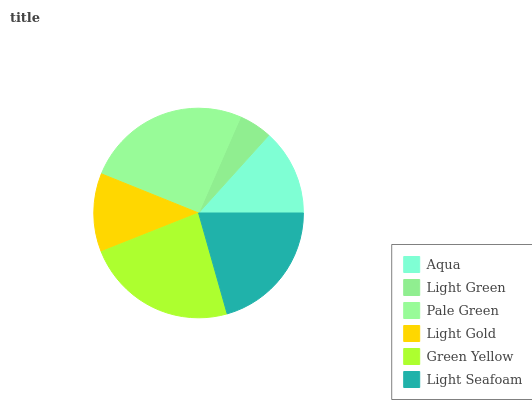


--- Example 2 ---
Question: Is Forest Green the smoothest?
True Answer: yes.

Baseline: yes.
  Reasoning: Both lines are smooth and linear, but Forest Green shows a steady increase from bottom-left to top-right with a consistent positive slope, while Orchid shows a steady decrease with a consistent negative slope. Both appear equally smooth, but Forest Green's upward trajectory is more typical of what we consider 'smooth growth'.

With Crop Tool (3 crops): no.
  Reasoning: Both Forest Green and Orchid are equally smooth, appearing as perfectly straight lines with constant slopes. Forest Green is not 'the smoothest' because it is not smoother than Orchid - they have equal smoothness.


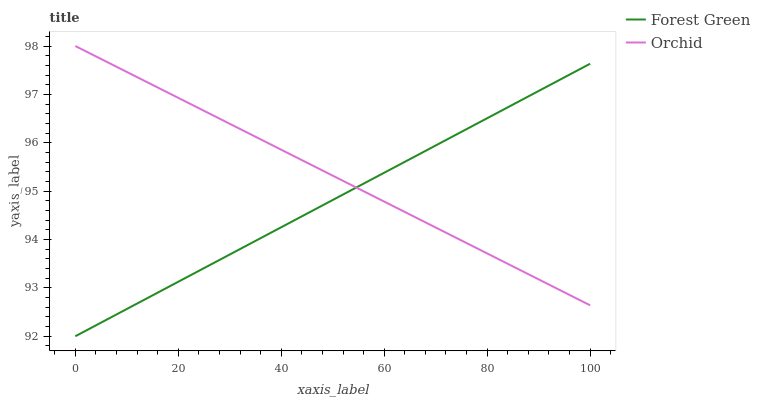


--- Example 3 ---
Question: Is Medium Turquoise the roughest?
True Answer: yes.

Baseline: yes.
  Reasoning: Looking at the scatter plot, Medium Turquoise (light blue dots) shows the most variation and irregular pattern, starting near the bottom, jumping up around x=20-40, then dropping back down. This erratic behavior makes it the roughest/most volatile line compared to the others which show smoother, more consistent trends.

With Crop Tool (4 crops): no.
  Reasoning: Medium Turquoise shows a relatively smooth bump pattern (going from 97 to about 97.6 and back to 97), but Sandy Brown exhibits more irregular fluctuations with multiple ups and downs in the 98.5-99 range, making it rougher than Medium Turquoise. Medium Mint also shows greater overall variation, though its changes are smoother.


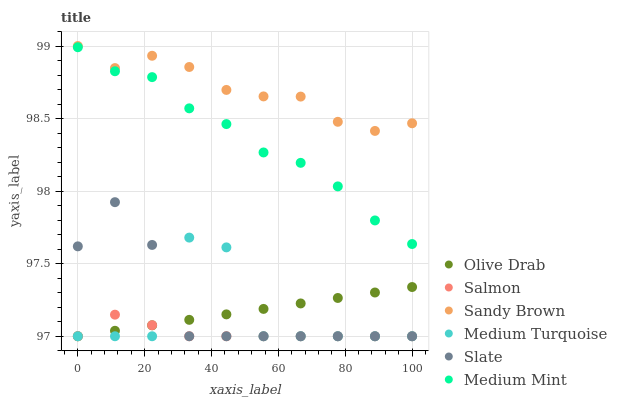

In [128]:
# Show examples of worsened cases (if any)
if worsened_cases:
    print("\n" + "="*60)
    print("CASES WHERE CROP TOOL HURT")
    print("="*60)
    
    for i, (base, crop) in enumerate(worsened_cases[:3]):  # Show up to 3
        # Find the original sample
        sample = next(s for s in samples if s["id"] == base["id"])
        
        print(f"\n--- Example {i+1} ---")
        print(f"Question: {base['question']}")
        print(f"True Answer: {base['true_answer']}")
        print(f"\nBaseline: {base['predicted_answer']}")
        print(f"  Reasoning: {base.get('reasoning', 'N/A')}")
        print(f"\nWith Crop Tool ({crop['tool_calls']} crops): {crop['predicted_answer']}")
        print(f"  Reasoning: {crop.get('reasoning', 'N/A')}")
        display(sample['image'])

## Tool Usage Analysis

Let's analyze how Claude uses the crop tool.

In [129]:
# Analyze tool usage patterns
crop_counts = [r["tool_calls"] for r in crop_results]

print("TOOL USAGE STATISTICS")
print("=" * 40)
print(f"Total questions: {len(crop_results)}")
print(f"Questions where crop was used: {sum(1 for c in crop_counts if c > 0)}")
print(f"Questions with no crops: {sum(1 for c in crop_counts if c == 0)}")
print(f"\nCrop count distribution:")
for i in range(max(crop_counts) + 1):
    count = sum(1 for c in crop_counts if c == i)
    if count > 0:
        print(f"  {i} crops: {count} questions ({count/len(crop_results):.1%})")

# Accuracy by crop usage
print("\nAccuracy by crop usage:")
used_crop = [r for r in crop_results if r["tool_calls"] > 0]
no_crop = [r for r in crop_results if r["tool_calls"] == 0]

if used_crop:
    acc_with = sum(1 for r in used_crop if r["true_answer"] == r["predicted_answer"]) / len(used_crop)
    print(f"  With crop tool: {acc_with:.1%} ({len(used_crop)} questions)")
if no_crop:
    acc_without = sum(1 for r in no_crop if r["true_answer"] == r["predicted_answer"]) / len(no_crop)
    print(f"  Without crop tool: {acc_without:.1%} ({len(no_crop)} questions)")

TOOL USAGE STATISTICS
Total questions: 50
Questions where crop was used: 50
Questions with no crops: 0

Crop count distribution:
  1 crops: 21 questions (42.0%)
  2 crops: 5 questions (10.0%)
  3 crops: 10 questions (20.0%)
  4 crops: 8 questions (16.0%)
  5 crops: 3 questions (6.0%)
  6 crops: 2 questions (4.0%)
  8 crops: 1 questions (2.0%)

Accuracy by crop usage:
  With crop tool: 88.0% (50 questions)


## Conclusion

This notebook demonstrated how providing Claude with a **crop tool** can improve its performance on chart question answering tasks using the FigureQA dataset.

### Key Takeaways

1. **Crop tools enable detailed analysis**: Claude can zoom into specific regions of charts to read exact values or compare elements more precisely.

2. **Useful for comparison questions**: Questions asking "Is X greater than Y?" often benefit from zooming into the relevant data points.

3. **Legend identification**: Cropping the legend area can help Claude correctly identify which color corresponds to which category.

### When Crop Tools Help Most

Based on the FigureQA evaluation, crop tools are particularly useful for:
- **Close comparisons**: When two values are similar and hard to distinguish at full resolution
- **Small text**: Reading axis labels, legend entries, or data labels
- **Dense charts**: Charts with many overlapping elements
- **Color identification**: Matching colors in the chart to legend entries


## Bonus: Using the Claude Agent SDK

The [Claude Agent SDK](https://github.com/anthropics/claude-agent-sdk-python) provides an alternative way to implement custom tools using **in-process MCP servers**. This approach offers several benefits:

- **No subprocess management** - Tools run in the same Python process
- **Better performance** - No IPC overhead for tool calls  
- **Easier debugging** - All code runs in one process
- **Type safety** - Direct Python function calls with type hints

Let's implement the same crop tool using the Agent SDK.

In [ ]:
%pip install claude-agent-sdk

In [131]:
import asyncio

from claude_agent_sdk import ClaudeAgentOptions, ClaudeSDKClient, create_sdk_mcp_server, tool

# Store the current image for the crop tool to access
current_image: PILImage.Image | None = None


@tool(
    "crop_image",
    "Crop a region of the chart image to examine it more closely. Use normalized coordinates (0-1) where (0,0) is the top-left corner and (1,1) is the bottom-right corner.",
    {"x1": float, "y1": float, "x2": float, "y2": float},
)
async def crop_image_tool(args: dict):
    """Crop tool implementation for the Agent SDK."""
    global current_image
    if current_image is None:
        return {"content": [{"type": "text", "text": "Error: No image available"}]}

    x1, y1, x2, y2 = args["x1"], args["y1"], args["x2"], args["y2"]

    # Validate coordinates
    if not all(0 <= c <= 1 for c in [x1, y1, x2, y2]):
        return {"content": [{"type": "text", "text": "Error: Coordinates must be between 0 and 1"}]}
    if x1 >= x2 or y1 >= y2:
        return {"content": [{"type": "text", "text": "Error: Invalid bounding box"}]}

    w, h = current_image.size
    left, top, right, bottom = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
    cropped = current_image.crop((left, top, right, bottom))

    return {
        "content": [
            {"type": "text", "text": f"Cropped region: ({x1:.2f},{y1:.2f}) to ({x2:.2f},{y2:.2f}) - {cropped.width}x{cropped.height}px"},
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": pil_to_base64(cropped)}},
        ]
    }


# Create the SDK MCP server with our crop tool
crop_server = create_sdk_mcp_server(
    name="crop-tools",
    version="1.0.0",
    tools=[crop_image_tool],
)

### Running Classification with the Agent SDK

Now let's use the `ClaudeSDKClient` to answer chart questions with our crop tool:

In [132]:
async def answer_with_agent_sdk(sample: dict) -> dict:
    """Answer a chart question using the Claude Agent SDK with the crop tool."""
    global current_image
    current_image = sample["image"]
    image_data = pil_to_base64(sample["image"])

    options = ClaudeAgentOptions(
        mcp_servers={"crop": crop_server},
        allowed_tools=["mcp__crop__crop_image"],
    )

    prompt = f"""Look at this chart image and answer the following yes/no question.

Question: {sample['question']}

You have access to a crop_image tool to zoom into specific regions if needed.
When ready, provide your answer as JSON: {{"answer": "<yes.|no.>", "reasoning": "<brief explanation>"}}

<image>
data:image/png;base64,{image_data}
</image>"""

    tool_calls = 0
    final_response = ""

    async with ClaudeSDKClient(options=options) as client:
        await client.query(prompt)

        async for message in client.receive_response():
            # Handle AssistantMessage with content blocks
            if hasattr(message, "content") and isinstance(message.content, list):
                for block in message.content:
                    if hasattr(block, "text"):
                        final_response = block.text
                    elif hasattr(block, "name"):  # ToolUseBlock has 'name'
                        tool_calls += 1

    result = extract_answer(final_response)
    return {
        "id": sample["id"],
        "question": sample["question"],
        "true_answer": sample["true_answer"],
        "tool_calls": tool_calls,
        **result,
    }

In [133]:
# Test the Agent SDK implementation on a few samples
test_samples = samples[:10]

print("Testing Agent SDK implementation...")
print("=" * 60)

sdk_results = []
for i, sample in enumerate(test_samples):
    print(f"[{i+1}/{len(test_samples)}]", end=" ")
    result = await answer_with_agent_sdk(sample)
    sdk_results.append(result)

    status = "correct" if result["true_answer"] == result["predicted_answer"] else "WRONG"
    print(f"{result['true_answer']:>3} -> {result['predicted_answer']:>7} [{status}] (crops: {result['tool_calls']})")

sdk_correct = sum(1 for r in sdk_results if r["true_answer"] == r["predicted_answer"])
print(f"\nAgent SDK Accuracy: {sdk_correct}/{len(sdk_results)} ({sdk_correct/len(sdk_results):.1%})")

Testing Agent SDK implementation...
[1/10] no. ->     no. [correct] (crops: 1)
[2/10] yes. ->    yes. [correct] (crops: 2)
[3/10] yes. ->    yes. [correct] (crops: 1)
[4/10] yes. ->     no. [WRONG] (crops: 1)
[5/10] no. ->    yes. [WRONG] (crops: 3)
[6/10] yes. ->     no. [WRONG] (crops: 1)
[7/10] yes. ->    yes. [correct] (crops: 1)
[8/10] yes. ->     no. [WRONG] (crops: 1)
[9/10] yes. ->    yes. [correct] (crops: 1)
[10/10] yes. ->    yes. [correct] (crops: 1)

Agent SDK Accuracy: 6/10 (60.0%)


### Key Differences: Anthropic SDK vs Claude Agent SDK

| Aspect | Anthropic SDK (`anthropic.Anthropic`) | Claude Agent SDK (`ClaudeSDKClient`) |
|--------|---------------------------------------|--------------------------------------|
| **Tool Definition** | JSON schema dictionary | `@tool` decorator on Python functions |
| **Tool Execution** | Manual loop handling `tool_use` responses | Automatic via in-process MCP server |
| **Response Handling** | Synchronous, manual message processing | Async generator with streaming |
| **Image Input** | Direct base64 in message content | Base64 in prompt text (data URI format) |
| **Best For** | Direct API control, vision tasks | Complex agents, multiple tools, Claude Code integration |

The Claude Agent SDK wraps Claude Code and is particularly useful when:
- Building agents with multiple custom tools
- You want cleaner separation between tool logic and conversation handling
- You need to mix custom tools with external MCP servers
- You're building on top of Claude Code's capabilities